In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


In [ ]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Load dataset
dataset = datasets.ImageFolder("/content/drive/MyDrive/Customdata", transform=transform)
train_length = int(len(dataset) * 0.7)
val_length = int(len(dataset) * 0.15)
test_length = len(dataset) - train_length - val_length
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_length, val_length, test_length])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)



In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # New Convolutional Layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # New Convolutional Layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),  # Adjust input size based on the last layer's output
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
model = CNN(num_classes=3)
print(model)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Seq

In [ ]:
# Initialize the model
num_classes = len(dataset.classes)
model = CNN(num_classes).to(device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
         MaxPool2d-9          [-1, 256, 28, 28]               0
           Conv2d-10          [-1, 512, 28, 28]       1,180,160
             ReLU-11          [-1, 512, 28, 28]               0
        MaxPool2d-12          [-1, 512, 14, 14]               0
           Conv2d-13          [-1, 512, 14, 14]       2,359,808
             ReLU-14          [-1, 512,

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Changed to Adam optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)  # ReduceLROnPlateau scheduler


In [ ]:

# Training loop with early stopping
epochs = 50
best_val_loss = float('inf')
epochs_without_improvement = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
for epoch in range(epochs):
    # ... (training code remains the same)
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100.0 * train_correct / train_total

    # Validation loop
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            # ... (validation code remains the same)
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = 100.0 * val_correct / val_total

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{50}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= 10:
            print("Early stopping triggered!")
            break

    # Update learning rate scheduler
    scheduler.step(val_loss)


Epoch 1/50: Train Loss: 1.1109, Train Acc: 40.48%, Val Loss: 1.0954, Val Acc: 45.13%
Epoch 2/50: Train Loss: 1.0168, Train Acc: 47.92%, Val Loss: 0.9930, Val Acc: 50.88%
Epoch 3/50: Train Loss: 0.9633, Train Acc: 51.56%, Val Loss: 0.9892, Val Acc: 50.88%
Epoch 4/50: Train Loss: 0.9496, Train Acc: 52.60%, Val Loss: 0.9546, Val Acc: 49.34%
Epoch 5/50: Train Loss: 0.9261, Train Acc: 53.93%, Val Loss: 0.9510, Val Acc: 51.11%
Epoch 6/50: Train Loss: 0.9160, Train Acc: 54.12%, Val Loss: 0.9652, Val Acc: 50.00%
Epoch 7/50: Train Loss: 0.9267, Train Acc: 54.55%, Val Loss: 0.9769, Val Acc: 52.65%
Epoch 8/50: Train Loss: 0.8944, Train Acc: 57.67%, Val Loss: 0.9193, Val Acc: 53.10%
Epoch 9/50: Train Loss: 0.8430, Train Acc: 59.99%, Val Loss: 0.8741, Val Acc: 61.50%
Epoch 10/50: Train Loss: 0.8198, Train Acc: 61.65%, Val Loss: 0.8145, Val Acc: 60.84%
Epoch 11/50: Train Loss: 0.8180, Train Acc: 62.55%, Val Loss: 0.8745, Val Acc: 59.29%
Epoch 12/50: Train Loss: 0.8028, Train Acc: 62.55%, Val Loss: 0

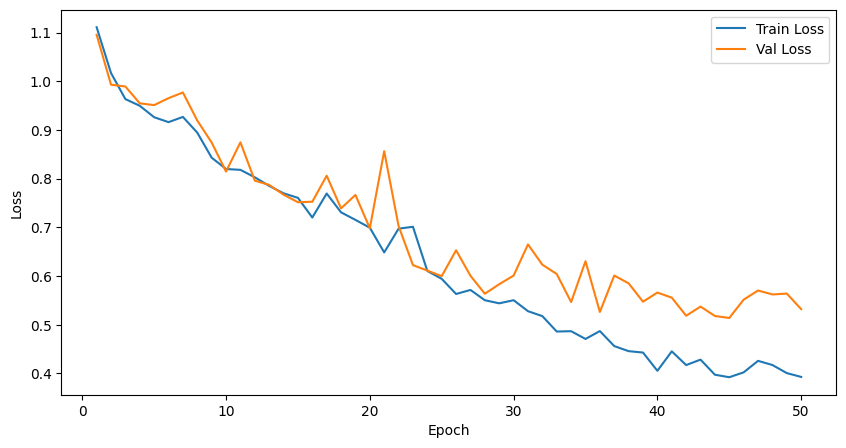

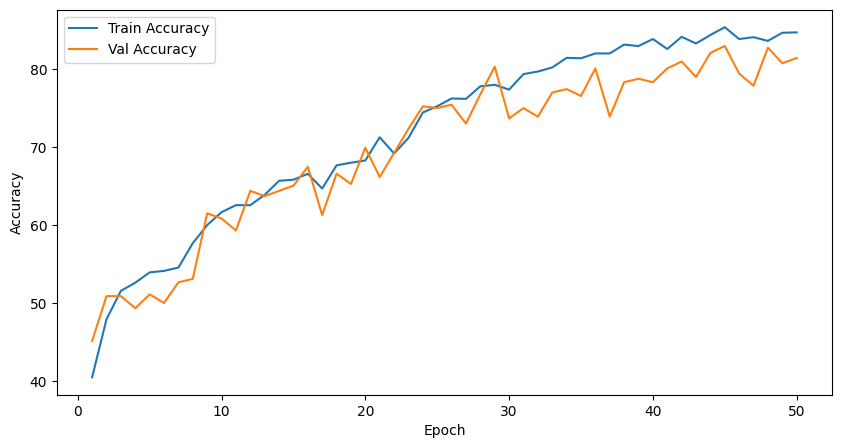

In [ ]:

    # ... (rest of the code remains the same)
    # Plotting the training history
plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), history['train_loss'], label='Train Loss')
plt.plot(range(1, 51), history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), history['train_acc'], label='Train Accuracy')
plt.plot(range(1, 51), history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
import itertools  # Add this line to import the itertools module


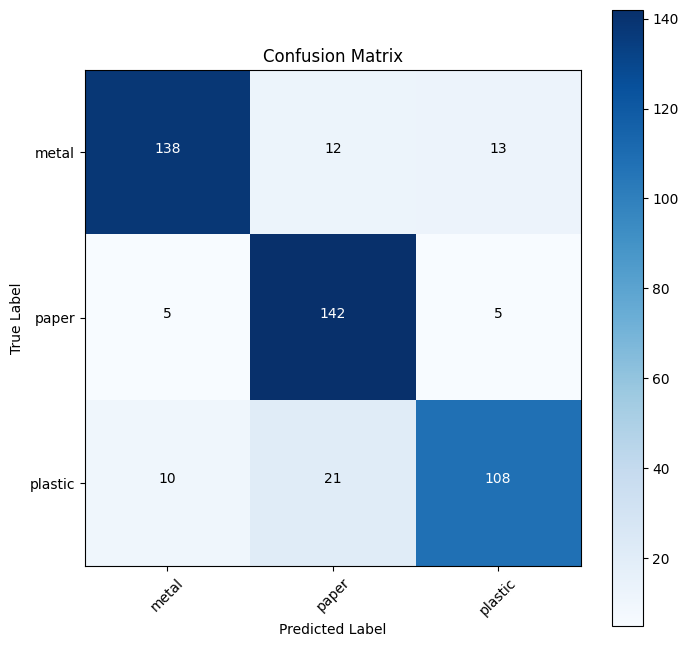

In [ ]:

# Testing the model
model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Plotting the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(dataset.classes)), dataset.classes, rotation=45)
plt.yticks(np.arange(len(dataset.classes)), dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add true label counts as text annotations
thresh = cm.max() / 2.  # Threshold for text visibility
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       163
           1       0.81      0.93      0.87       152
           2       0.86      0.78      0.82       139

    accuracy                           0.85       454
   macro avg       0.86      0.85      0.85       454
weighted avg       0.86      0.85      0.85       454

